In [1]:
%matplotlib inline

In [27]:
import numpy as np

import pprint
import time
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn.functional as F

from matplotlib.axes import Axes

If you recall, our breakdown of machine learning was:
- data
- model
- training.
And we are trying to cover the paper [Backpropagation Applied to Handwritten Zip Code Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf). 

We just covered the model, so we're going to move onto training.
Again, we're not going to implement the exact method of the paper.
The source code is available, but it is written in the Lisp programming language.
Further, the method is a little difficult to understand without seeing **stochastic gradient descent** first.

I've mentioned this word several times and it's a phrase that describes exactly what it does.
We have to go word by word:
- stochastic: it's part of a random process, e.g. coin flipping, dice, etc.
- gradient: this is the derivate of a multivariable function.
- descent: the act of going down.

We pick an example from our dataset **stochastically**, e.g. at random, then use that to calculate the **gradient** of the loss function with respect to our neural network weights, then we **descend** the weights in the direction of that gradient.
Mathematically, if $\textbf{W}$ represents our weights, $L$ our loss function, and $\alpha$ is a constant that we call the **learning rate**, then we update the weights $\textbf{W}$ with the following rule:
$$
\textbf{W} = \textbf{W} - \alpha \frac{\partial L}{\partial \textbf{W}}
$$

Let's go into more detail about what a gradient is.
First, we'll have to go into what a derviative is.
There are a number of different ways to think about derivatives, but what I think is the most important is that the derivative is the slope of the tangent line to a function.
The tangent line intersects the function without passing through it, if we zoom in enough.

Let's look at an example.
We're going to look at the derivative of $f(x) = x^{3} + 2x + 1$.

The derivative of this function is $f^{\prime}(x) = 3x^{2} + 2$.
The derivative of $f(x)$ at $1$ is $5$.

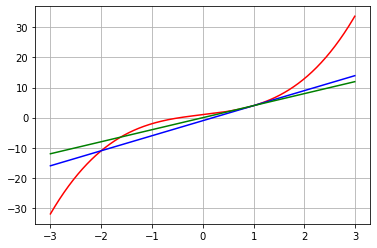

In [3]:
x = np.arange(-3.0, 3.0, 0.01)
y = x ** 3 + 2 * x + 1
deriv = 5 * x - 1
nontangent = 4 * x

plt.plot(x, y, 'r')
plt.plot(x, deriv, 'b')
plt.plot(x, nontangent, 'g')
plt.grid()
plt.show()

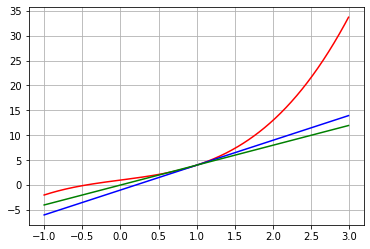

In [4]:
x = np.arange(-1.0, 3.0, 0.01)
y = x ** 3 + 2 * x + 1
deriv = 5 * x - 1
nontangent = 4 * x

plt.plot(x, y, 'r')
plt.plot(x, deriv, 'b')
plt.plot(x, nontangent, 'g')
plt.grid()
plt.show()

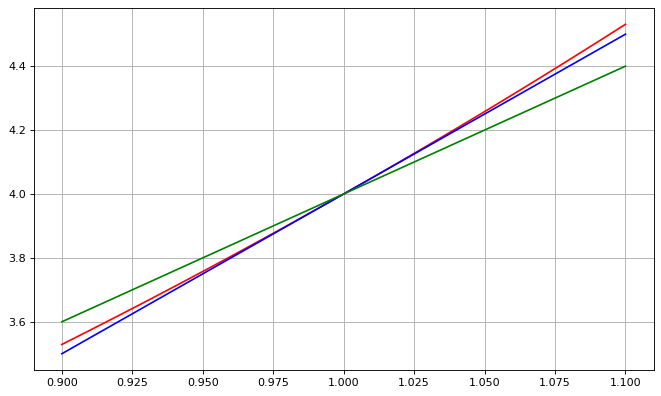

In [8]:
x = np.arange(0.9, 1.1, 0.01)
y = x ** 3 + 2 * x + 1
deriv = 5 * x - 1
nontangent = 4 * x

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(x, y, 'r')
plt.plot(x, deriv, 'b')
plt.plot(x, nontangent, 'g')
plt.grid()
plt.show()

There is a rigorous definition.
The nice thing is that we can use this definition to calculate some derivatives of well-known functions.
If $f(x)$ is a function, then the **derivative** is defined as
$$
\frac{d f}{dx}\bigg|_{x_0} = f^{\prime}(x_{0}) = \lim_{h \to 0} \frac{f(x_{0} + h) - f(x_{0})}{h}
$$

Let's see if we can calculate the derivative with this definition and numpy.
Let's try to write a function:

In [84]:
def derivative(f, x_0, h):
    # f is a function and x_0 is the point it is evaluated at.
    # h should be small
    raise NotImplementedError

In [68]:
derivative(lambda lam: lam ** 2, 1, 0.0001)

NotImplementedError: 

This method is called the method of finite differences.

Due to numerical stability, this isn't the best way to write the function.
Because $h$ should be very small, it can lead to instabilities.
A better definition to use is:
$$
\lim_{h \to 0} \frac{f(x_{0} + h) - f(x_{0} - h)}{2h}
$$

In [85]:
def better_derivative(f, x_0, h):
    # f is a function and x_0 is the point it is evaluated at.
    # h should be small
    raise NotImplementedError

In [70]:
derivative(lambda lam: lam ** 2, 1, 1e-5), better_derivative(lambda lam: lam ** 2, 1, 1e-5)

NotImplementedError: 

In [86]:
# We're looking at how close each corresponds to reality.

x = np.arange(-0.00001, 0.00001, 0.0000001)
y = x ** 3
z = 3 * x ** 2
deriv = np.array([derivative(lambda x: x ** 3, x_0, 1e-5) for x_0 in x])
better_deriv = np.array([better_derivative(lambda x: x ** 3, x_0, 1e-5) for x_0 in x])

plt.plot(x, y, 'r')
plt.plot(x, deriv, 'b')
plt.plot(x, better_deriv, 'g')
plt.plot(x, z, 'y')
plt.grid()
plt.show()

NotImplementedError: 

Let's look at trying to calculate the limit of $f(x) = x^{2}$ with the definition.
$$
f^{\prime}(x) = \lim_{h \to 0} \frac{(x_{0} + h)^{2} - x_{0}^{2}}{h} = 
\lim_{h \to 0} \frac{x_{0}^{2} + 2x_{0}h + h^{2} - x_{0}^{2}}{h} = 
\lim_{h \to 0} \frac{2x_{0}h + h^{2}}{h} = \lim_{h \to 0} 2x_{0} + h = 2x_{0}.
$$

Typically, in practice, you either use numerical derivatives, which is what we implemented in the derivative functions above or you use a table of derivatives and several rules to calculate the derivatives.
It's similar to how we learn how to add multiple digit numbers or add the two numbers together.
We memorize the single digit multiplications or single digit additions, then we have an algorithm for combining them together.

We don't have to memorize the derivatives, but we should have a look up table and rules handy.
I'm going to put a list here and some derivatives.
If you ever need a reference [Wikipedia's derivatives page](https://en.wikipedia.org/wiki/Derivative#Rules_of_computation) can work as a reference.

We're going to go through some rules:

**Constant Multiplication Rule**

If $a$ is a constant and $f$ is a differentiable function (it has a derivative), then
$$
(a f)^{\prime}(x) = a f^{\prime}(x).
$$

**Addition/Subtraction Rule**

If $f$ and $g$ are differentiable functions, then
$$
(f \pm g)^{\prime}(x) = f^{\prime}(x) \pm g^{\prime}(x).
$$

**Multiplication (or Product) Rule**

If $f$ and $g$ are differentiable functions, then
$$
(f \cdot g)^{\prime}(x) = f^{\prime}(x) \cdot g^{\prime}(x).
$$

**Quotient Rule**

If $f$ and $g$ are differentiable functions, then
$$
\left(\frac{f}{g}\right)^{\prime}(x) = \frac{f^{\prime}(x) \cdot g - f \cdot g^{\prime}(x)}{g(x)^{2}}.
$$

**Chain Rule**

If $g$ and $h$ are differentiable functions and $f(x) = h(g(x))$, then
$$
f^{\prime}(x) = h^{\prime}(g(x)) \cdot g^{\prime}(x).
$$

**Polynomial**

If $f(x) = x^{n}$, where $n$ is an integer, then
$$
f^{\prime}(x) = nx^{n-1}
$$

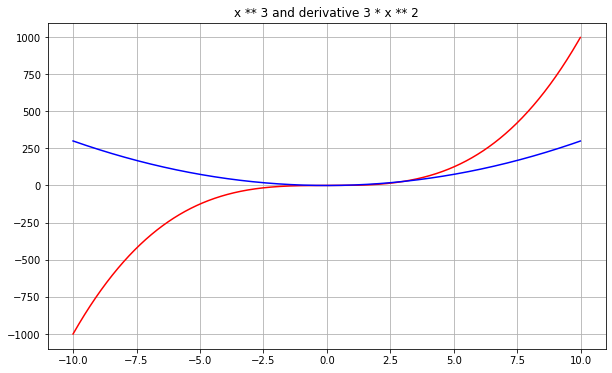

In [17]:
x = np.arange(-10.0, 10.0, 0.01)
y = x ** 3
deriv = 3 * x ** 2

plt.figure(figsize=(10, 6))
plt.title('x ** 3 and derivative 3 * x ** 2')
plt.plot(x, y, 'r')
plt.plot(x, deriv, 'b')
plt.grid()
plt.show()

**Exponential**

If $f(x) = e^{x}$, then
$$
f^{\prime}(x) = e^{x}.
$$

If $a$ is a constant and $f(x) = a^{x}$, then
$$
f^{\prime}(x) = (\log a) a^{x}.
$$

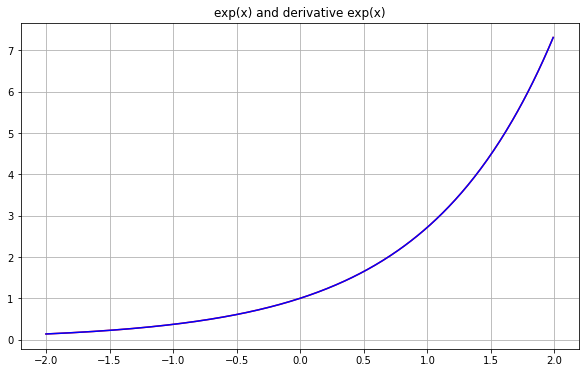

In [15]:
x = np.arange(-2.0, 2.0, 0.01)
y = np.exp(x)
deriv = np.exp(x)

plt.figure(figsize=(10, 6))
plt.title('exp(x) and derivative exp(x)')
plt.plot(x, y, 'r')
plt.plot(x, deriv, 'b')
plt.grid()
plt.show()

**Logarithm**

If $f(x) = \log x$, then
$$
f^{\prime}(x) = \frac{1}{x}.
$$

If $a$ is a constant and $f(x) = \log_{a} x$, then
$$
f^{\prime}(x) = \frac{1}{(\log a) x}.
$$

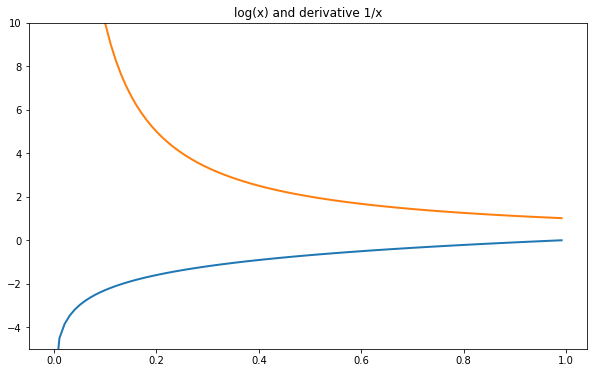

In [51]:
x = np.arange(0.001, 1, 0.01)
y = np.log(x)
deriv = 1 / (x)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)

line, = ax.plot(x, y, lw=2)
line, = ax.plot(x, deriv, lw=2)

ax.set_ylim(-5, 10)
ax.set_title('log(x) and derivative 1/x')
plt.show()

**Trigonometric**

- if $f(x) = \sin(x)$, then $$f^{\prime}(x) = \cos(x).$$
- if $f(x) = \cos(x)$, then $$f^{\prime}(x) = -sin(x).$$

Now, we move onto multivariable derivatives, specifically gradients!
First, let's look at some examples of multivariable functions.

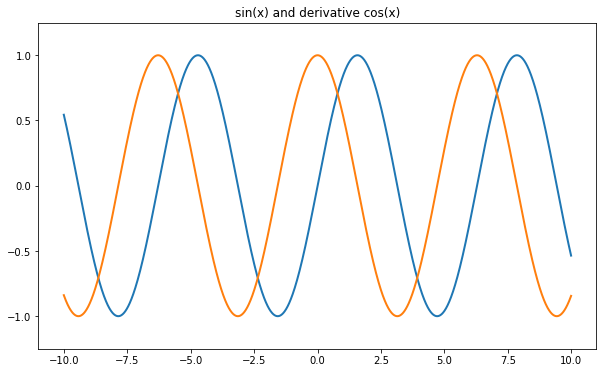

In [52]:
x = np.arange(-10, 10, 0.01)
y = np.sin(x)
deriv = np.cos(x)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)

line, = ax.plot(x, y, lw=2)
line, = ax.plot(x, deriv, lw=2)

ax.set_ylim(-1.25, 1.25)
ax.set_title('sin(x) and derivative cos(x)')
plt.show()

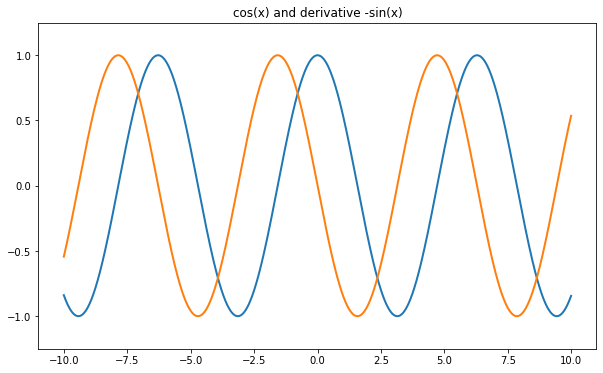

In [53]:
x = np.arange(-10, 10, 0.01)
y = np.cos(x)
deriv = -np.sin(x)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)

line, = ax.plot(x, y, lw=2)
line, = ax.plot(x, deriv, lw=2)

ax.set_ylim(-1.25, 1.25)
ax.set_title('cos(x) and derivative -sin(x)')
plt.show()

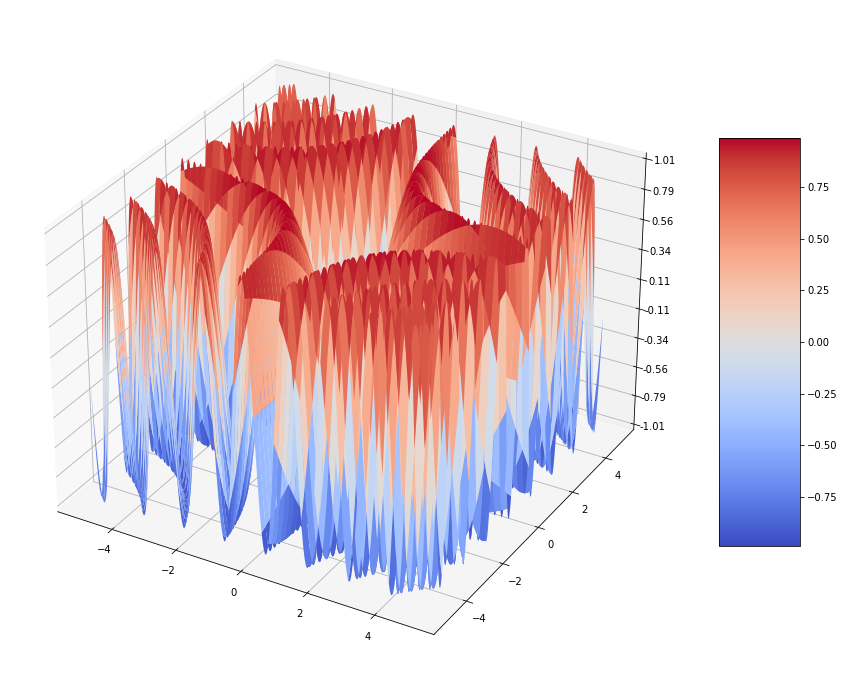

In [101]:
# Derived from example in https://matplotlib.org/stable/gallery/mplot3d/surface3d.html
from matplotlib import cm
from matplotlib.ticker import LinearLocator

plt.rcParams["figure.figsize"] = (15,15)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x = np.arange(-5, 5, 0.001)
y = np.arange(-5, 5, 0.001)
x, y = np.meshgrid(x, y)
z = np.sin(x * y)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Another example is
$$
f(x, y, z) = [xy, yz, xz].
$$
We're not going to graph this one, though.

The gradient of $f(x, y) = \sin(xy)$
$$
[y \cos(xy), x \cos(xy)].
$$
The gradient of $f(x, y, z) = [xy, yz, xz]$ is
$$
\begin{pmatrix}
y & x & 0 \\
0 & z & y \\
z & 0 & x
\end{pmatrix}
$$

Let's go into the textbook definition:

**Multivariable Differentiation**

If $f: \mathbb{R}^{m} \to \mathbb{R}^{n}$ is a function and $\textbf{a}$ is an $m$-dimensional vector, then we say $f$ is **differentiable** at $\textbf{a}$ if there exists an $n \times m$ matrix $\textbf{B}$ such that:
$$
\frac{f(\textbf{a} + \textbf{h}) - f(\textbf{a}) - \textbf{B} \textbf{h}}{|\textbf{h}|} \to 0 \textrm{ as } \textbf{h} \to \textbf{0}.
$$
We denote the matrix $\textbf{B}$ as $Df(\textbf{a})$.

The problem with this definition is that it's difficult to actually make calculations of derivatives with.
We'll have some theorems later that tell us how we can calculate multivariable derivatives with single variable derivatives.

Let's do an example.

Suppose we have $f(\textbf{x}) = \textbf{A}\cdot \textbf{x} + \textbf{b}$, where $\textbf{x}$ and $\textbf{b}$ are $n$-dimensional vectors and $\textbf{A}$ is an $n \times m$ matrix, then
$$
f(\textbf{a} + \textbf{h}) - f(\textbf{a}) = \textbf{A}\cdot (\textbf{a} + \textbf{h}) + \textbf{b} - \textbf{A}\cdot \textbf{a} + \textbf{b} = \textbf{A}\cdot \textbf{a} + \textbf{A}\cdot \textbf{h} + \textbf{b} - \textbf{A}\cdot \textbf{a} + \textbf{b} = \textbf{A} \cdot \textbf{h}.
$$

Because $\textbf{h} / |\textbf{h}| \to \textbf{0}$ as $\textbf{h} \to 0$, that means that our derivative in this case is $\textbf{A}$.
Here's the theorem that you would likely use in practice to calculate partial derivatives:

**Theorem**

If $f: \mathbb{R}^{m} \to \mathbb{R}$ is differentiable at $\textbf{a}$, then
$$
Df(\textbf{a}) = [D_{1} f(\textbf{a}), \ldots, D_{m} f(\textbf{a})],
$$
where $D_{i}f(\textbf{a}) = \frac{\partial f(\textbf{a})}{\partial x_{i}}$.

**Theorem**

If $f : \mathbb{R}^{m} \to \mathbb{R}^{n}$ is a differentiable function at $\textbf{a}$ and $f_{i} : \mathbb{R}^{m} \to \mathbb{R}$ are the $i$th components of $f$, i.e.
$$
f(\textbf{x}) = 
\begin{pmatrix}
f_{1}(\textbf{x}) \\
\vdots \\
f_{n}(\textbf{x})
\end{pmatrix}
$$
then
- $f$ is differentiable at $\textbf{a}$ if and only if each $f_{i}$ is differentiable at $\textbf{a}$.
- If $f$ is differentiable at $\textbf{a}$, then
$$
Df(\textbf{a}) = 
\begin{pmatrix}
D f_{1}(\textbf{a}) \\
\vdots \\
D f_{n}(\textbf{a})
\end{pmatrix} =
\begin{pmatrix}
D_{1} f_{1}(\textbf{a}) & D_{2} f_{1}(\textbf{a}) & \cdots & D_{m} f_{1}(\textbf{a}) \\
D_{1} f_{2}(\textbf{a}) & D_{2} f_{2}(\textbf{a}) & \cdots & D_{m} f_{2}(\textbf{a}) \\
\vdots & \vdots & \ddots & \vdots \\
D_{1} f_{n}(\textbf{a}) & D_{2} f_{n}(\textbf{a}) & \cdots & D_{m} f_{n}(\textbf{a}) \\
\end{pmatrix}
$$

We have rules for gradients similar to the rules we saw before:

**Scalar Multiplication Rule**

If $\alpha$ is a scalar (one dimensional constant) and $f : \mathbb{R}^{m} \to \mathbb{R}^{n}$ is differentiable at $\textbf{a}$, then
$$
D(\alpha f)(\textbf{a}) = \alpha Df(\textbf{a})
$$

**Addition/Subtraction Rule**

If $f : \mathbb{R}^{m} \to \mathbb{R}^{n}$ and $g : \mathbb{R}^{m} \to \mathbb{R}^{n}$ are differentiable at $\textbf{a}$, the
$$
D(f \pm g)(\textbf{a}) = Df(\textbf{a}) \pm Dg(\textbf{a})
$$

**Chain Rule**

If $f : \mathbb{R}^{m} \to \mathbb{R}^{n}$ is differentiable at $\textbf{a}$ and if $g : \mathbb{R}^{n} \to \mathbb{R}^{p}$ is differentiable at $f(\textbf{a}) = \textbf{b}$, then
$$
D(g \circ f)(\textbf{a}) = Dg(\textbf{b}) \cdot Df(\textbf{a})
$$
where the right hand side is matrix multiplication.

Finally, we're going to do an example of stochastic gradient descent with the function $f(x, y) = \sin(xy)$. We're going to try to find a point that is minimal.

In [181]:
def sgd(initial_weights, iters=1000000, learning_rate=1e-2):
    x, y = initial_weights
    for _ in range(iters):
        grad = [y * np.cos(x * y), x * np.cos(x * y)]
        x = x - learning_rate * grad[0]
        y = y - learning_rate * grad[1]
    return x, y

In [182]:
min_x, min_y = sgd((1, 1))
print(min_x, min_y)

2.4e-322 2.4e-322


In [185]:
[min_y * np.cos(min_x * min_y), min_x * np.cos(min_x * min_y)]

[2.4e-322, 2.4e-322]

This isn't the miniminum of $\sin (xy)$, the minimum value would be $-1$.
Why didn't this happen?
Well, the above calculation is the gradient and it's close to $[0, 0]$.
Unfortunately, if the gradient is near $0$, then weight updates stop.
This is called the **vanishing gradient** problem and was one of the major difficulties with training large neural networks.

Let's try different initial weights.

In [189]:
min_x, min_y = sgd((1, np.pi))
print(np.sin(min_x * min_y))

-1.0


So, what we did is change the initialization.
This was another method to guard against the vanishing gradient problems.
We'll talk about this more later.